In [1]:
#import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
np.random.seed(2)
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tensorflow.python.keras.utils.np_utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout,BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import model_from_json
from PIL import Image, ImageChops, ImageEnhance
import PIL
import os
import itertools
from tqdm import tqdm
tf.__version__

'2.4.1'

In [2]:
#ELA Conversion Function
def ELA(img_path, quality=100, threshold=60):
    TEMP = 'ela_' + 'temp.jpg'
    SCALE = 10
    original = Image.open(img_path)
    diff = ""

    try:
        original.save(TEMP, quality=90)
        temporary = Image.open(TEMP)
        diff = ImageChops.difference(original, temporary)

    except:
        original.convert('RGB').save(TEMP, quality=90)
        temporary = Image.open(TEMP)
        diff = ImageChops.difference(original.convert('RGB'), temporary)

    d = diff.load()
    WIDTH, HEIGHT = diff.size

    for x in range(WIDTH):
        for y in range(HEIGHT):
            r, g, b = d[x, y]
            modified_intensity = int(0.2989 * r + 0.587 * g + 0.114 * b)
            d[x, y] = modified_intensity * SCALE, modified_intensity * SCALE, modified_intensity * SCALE

    # Calculate the threshold value based on the provided input quality
    calculated_threshold = threshold * (quality / 100)

    # Create a binary mask based on the threshold and pixel differences
    binary_mask = diff.point(lambda p: 255 if p >= calculated_threshold else 0)

    return binary_mask

In [3]:
#Dataset Path, Original Images Path and Forged Images Path
dataset_path="/kaggle/input/image-forgery-detection/Dataset/"
path_original = 'Original/'
path_tampered = 'Forged/'

total_original = os.listdir(dataset_path+path_original)
total_tampered = os.listdir(dataset_path+path_tampered)



In [4]:
pristine_images = []
for i in total_original:
    pristine_images.append(dataset_path+path_original+i)
fake_images = []
for i in total_tampered:
    fake_images.append(dataset_path+path_tampered+i)

In [5]:
len(total_tampered),len(fake_images)

(6500, 6500)

In [6]:
image_size = (224,224)
output_path='./'

In [7]:
# os.rmdir(output_path+"resized_images/fake_images/")
# os.rmdir(output_path+"resized_images/pristine_images/")
# os.rmdir(output_path+"resized_images/")

In [8]:
#Resizing the images and saving in output
output_path='./'
if not os.path.exists(output_path+"resized_images/"):
#     os.makedirs(output_path+"resized_images/fake_masks/")
    os.makedirs(output_path+"resized_images/fake_images/")
    os.makedirs(output_path+"resized_images/pristine_images/")
    height = 224
    width = 224
#     p2=output_path+"resized_images/fake_masks/"
    p1=output_path+"resized_images/fake_images/"
    p3=output_path+"resized_images/pristine_images/"
    j=0
    for fake_image in tqdm(total_tampered):
        try:
            img=Image.open(dataset_path+path_tampered + fake_image).convert("RGB")
            img = img.resize((height, width), PIL.Image.ANTIALIAS)
            img.save(p1+fake_image)
            j+=1
        except:
            print("Encountered Invalid File : ",fake_image)
        
    j=0
    for pristine_image in tqdm(total_original):
        try:
            img=Image.open(dataset_path+path_original + pristine_image).convert("RGB")
            img = img.resize((height, width), PIL.Image.ANTIALIAS)
            img.save(p3+pristine_image)
            j+=1
        except:
            print("Invalid File : " ,pristine_image)
        
        
        
else:
    print('images resized,path exists')

100%|██████████| 6500/6500 [03:28<00:00, 31.22it/s]


In [9]:
resized_fake_image_path=output_path+"resized_images/fake_images/"
resized_pristine_image_path=output_path+"resized_images/pristine_images/"
resized_fake_image=os.listdir(resized_fake_image_path)
resized_pristine_image=os.listdir(resized_pristine_image_path)

In [10]:
len(resized_pristine_image)
# os.rmdir(ela_real)
# os.rmdir(ela_fake)
# os.rmdir('ELA_IMAGES/')

6500

In [11]:
ela_images_path=output_path+'/kaggle/input/image-forgery-detection/Dataset/'
ela_real=ela_images_path+'Original/'
ela_fake=ela_images_path+'Forged/'
if not os.path.exists(ela_images_path):
    os.makedirs(ela_images_path)
    os.mkdir(ela_real)
    os.mkdir(ela_fake)
    j=0
    for i in tqdm(resized_fake_image):
        ELA(resized_fake_image_path+i).save(ela_fake+i)

    j=0
    for i in tqdm(resized_pristine_image):
        ELA(resized_pristine_image_path+i).save(ela_real+i)

else:
    print('Images are already converted to ELA')

100%|██████████| 6500/6500 [06:12<00:00, 17.43it/s]


Displaying 10 ELA images converted from original images:


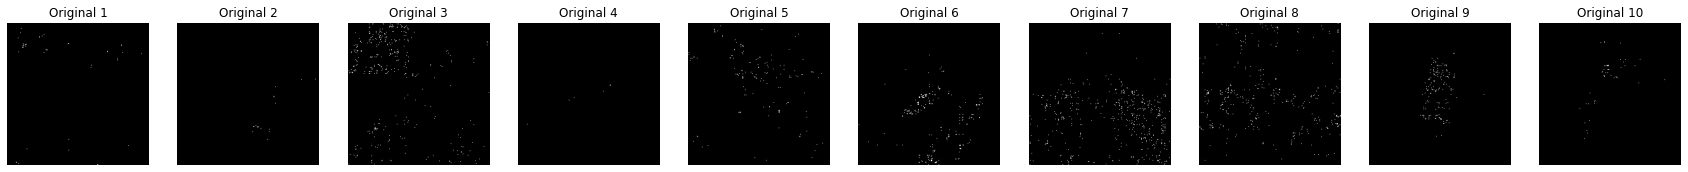

Displaying 10 ELA images converted from tampered images:


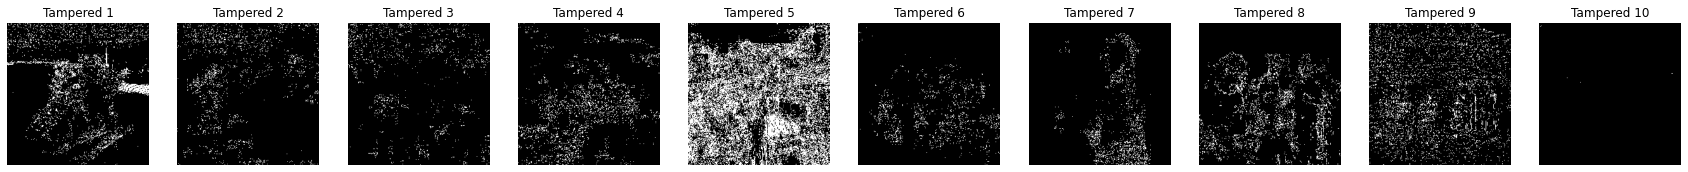

In [12]:
import matplotlib.pyplot as plt

# Function to display ELA images
def display_ela_images(ela_images, titles):
    fig, axes = plt.subplots(1, len(ela_images), figsize=(30, 30))
    for i, ax in enumerate(axes):
        ax.imshow(ela_images[i], cmap='gray')
        ax.axis('off')
        ax.set_title(titles[i])

# Display 10 ela images converted from the original images
print("Displaying 10 ELA images converted from original images:")
ela_original_images = [ELA(resized_pristine_image_path + i) for i in resized_pristine_image[0:10]]
titles_original = [f"Original {i+1}" for i in range(10)]
display_ela_images(ela_original_images, titles_original)
plt.show()

# Display 10 ELA images converted from the tampered images
print("Displaying 10 ELA images converted from tampered images:")
ela_tampered_images = [ELA(resized_fake_image_path + i) for i in resized_fake_image[0:10]]
titles_tampered = [f"Tampered {i+1}" for i in range(10)]
display_ela_images(ela_tampered_images, titles_tampered)
plt.show()

In [13]:
X=[]
Y=[]
j=0
for file in tqdm(os.listdir(ela_real)):
    img=Image.open(ela_real+file)
    img=np.array(img)
    X.append(img)
    Y.append(0)
    j+=1

j=0
for file in tqdm(os.listdir(ela_fake)):
    img=Image.open(ela_fake+file)
    img=np.array(img)
    X.append(img)
    Y.append(1)
    j+=1


100%|██████████| 6500/6500 [00:07<00:00, 886.26it/s]


In [14]:
X=np.array(X)
X.shape

(13000, 224, 224, 3)

In [15]:
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
x_train, x_dev, y_train, y_dev = train_test_split(X, Y, test_size=0.2, random_state=1,shuffle=True)
y_train=to_categorical(y_train,2)
y_dev=to_categorical(y_dev,2)

In [16]:
from tensorflow.keras.applications import DenseNet121, Xception, VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D,BatchNormalization,Dropout,MaxPooling2D
from tensorflow.keras.regularizers import l1,l2,l1_l2

# Create the model based on DenseNet121
base_model = DenseNet121(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

# Unfreeze the layers in the base model
for layer in base_model.layers:
    layer.trainable = True
x=base_model.output
x=Conv2D(1024,(3,3),padding='same',activation='relu')(x)
x=GlobalAveragePooling2D()(x)
x=Flatten()(x)
x=Dense(1024,activation='relu',kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))(x)
x=Dropout(0.8)(x)
x=Dense(16,activation='relu',kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))(x)
x=Dense(2,activation='softmax')(x)
model=Model(base_model.input,x)
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])


29089792/29084464 [==============================] - 0s 0us/step


In [17]:
epochs = 10
batch_size = 64

In [18]:
import keras
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10,verbose=1,restore_best_weights=True)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, patience = 10, verbose = 1)

In [19]:
hist = model.fit(x_train,y_train,
                 epochs = epochs, batch_size = batch_size,
                validation_data = (x_dev,y_dev),
                #callbacks = [early_stop,reduce_lr],
                verbose=1,shuffle=True)

Epoch 1/10
163/163 [==============================] - 79s 397ms/step - loss: 6.1370 - accuracy: 0.7736 - val_loss: 24.9866 - val_accuracy: 0.4892
Epoch 2/10
163/163 [==============================] - 61s 372ms/step - loss: 0.9802 - accuracy: 0.9677 - val_loss: 0.5407 - val_accuracy: 0.9662
Epoch 3/10
163/163 [==============================] - 61s 372ms/step - loss: 0.4517 - accuracy: 0.9686 - val_loss: 0.3030 - val_accuracy: 0.9704
Epoch 4/10
163/163 [==============================] - 61s 372ms/step - loss: 0.2761 - accuracy: 0.9731 - val_loss: 4.4394 - val_accuracy: 0.8200
Epoch 5/10
163/163 [==============================] - 61s 372ms/step - loss: 0.2288 - accuracy: 0.9648 - val_loss: 0.2020 - val_accuracy: 0.9658
Epoch 6/10
163/163 [==============================] - 61s 372ms/step - loss: 0.1792 - accuracy: 0.9696 - val_loss: 0.4187 - val_accuracy: 0.9315
Epoch 7/10
163/163 [==============================] - 61s 372ms/step - loss: 0.1506 - accuracy: 0.9723 - val_loss: 0.3433 - val_a

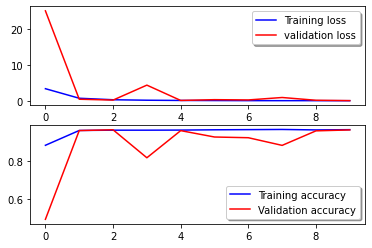

In [20]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1)
ax[0].plot(hist.history['loss'], color='b', label="Training loss")
ax[0].plot(hist.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(hist.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(hist.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [21]:
# pred[0:20]

[[1319    9]
 [  70 1202]]
Precision: 0.9925681255161024
Recall: 0.9449685534591195
F1 Score: 0.968183648811921
Accuracy: 0.9696153846153847
ROC-AUC Score: 0.9807585294006214


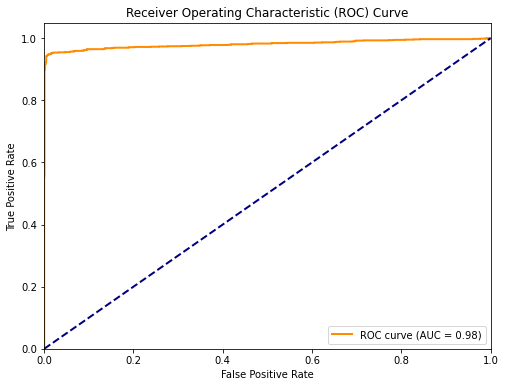

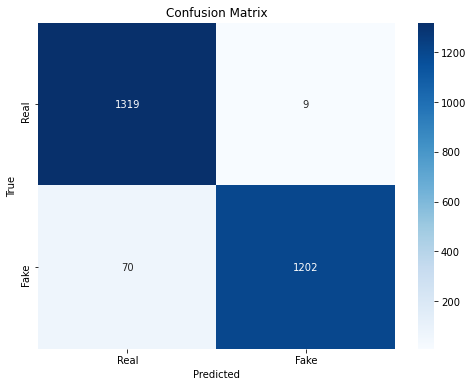

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, roc_curve, roc_auc_score, auc
import seaborn as sns

# Assuming you have the model already trained and 'x_dev' contains the validation data

# Get predictions from the model
y_pred = model.predict(x_dev)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels

# Convert one-hot encoded labels back to categorical labels
y_dev_classes = np.argmax(y_dev, axis=1)

# Generate confusion matrix
conf_matrix = confusion_matrix(y_dev_classes, y_pred_classes)
print(conf_matrix)
# Define class labels (0: real, 1: fake)
class_labels = ["Real", "Fake"]

# Calculate metrics
precision = precision_score(y_dev_classes, y_pred_classes)
recall = recall_score(y_dev_classes, y_pred_classes)
f1 = f1_score(y_dev_classes, y_pred_classes)
accuracy = accuracy_score(y_dev_classes, y_pred_classes)

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Accuracy:", accuracy)

# Calculate ROC curve and ROC-AUC
fpr, tpr, _ = roc_curve(y_dev_classes, y_pred[:, 1])  # Assuming 1 corresponds to "fake" class
roc_auc = auc(fpr, tpr)

print("ROC-AUC Score:", roc_auc)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


Prediction

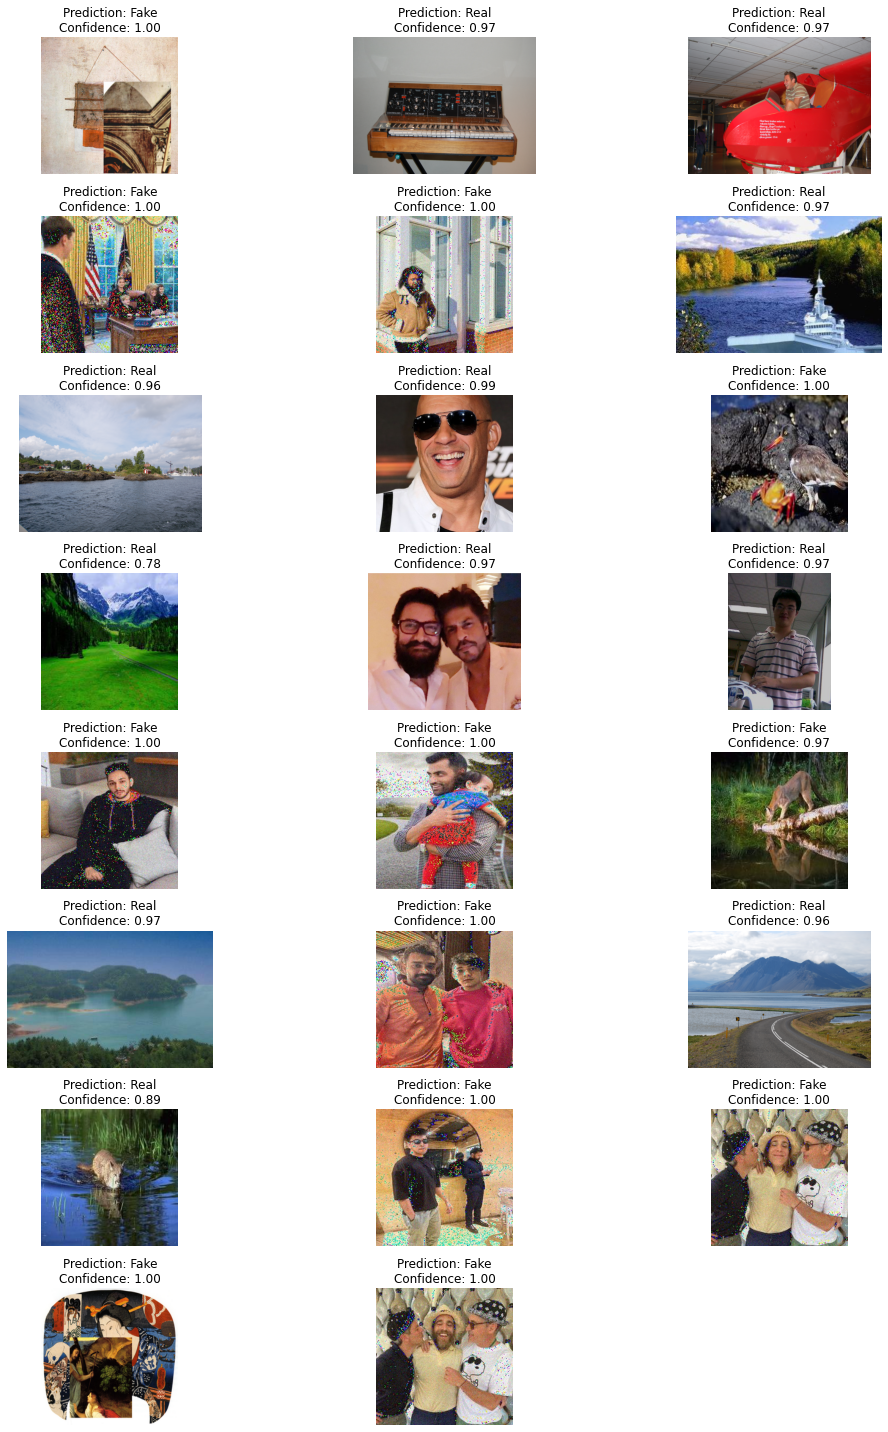

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.models import load_model


# Function to preprocess an image
def preprocess_image(image_path):
    img = ELA(image_path)
    img = img.resize((224, 224))  # Resize the image to match the input size of your model
    img = np.array(img) # Normalize pixel values to [0, 1]
    return img

# Path to the folder containing random images
image_folder = '/kaggle/input/input-random-image/Images/'



image_files = [f for f in os.listdir(image_folder) if f.endswith(('.png', '.jpg', '.jpeg'))]

num_images = len(image_files)
num_cols = 3  # Number of columns in the grid
num_rows = -(-num_images // num_cols)
plt.figure(figsize=(15, 20))

for i, image_file in enumerate(image_files):
    # Preprocess the image
    image_path = os.path.join(image_folder, image_file)
    preprocessed_img = preprocess_image(image_path)

    # Get predictions from the model
    pred_probs = model.predict(np.expand_dims(preprocessed_img, axis=0))[0]
    predicted_class = np.argmax(pred_probs)
    predicted_label = class_labels[predicted_class]
    confidence = pred_probs[predicted_class]

    # Set up the subplot
    plt.subplot(num_rows, num_cols, i + 1)
    plt.imshow(Image.open(image_path))
    plt.title(f"Prediction: {predicted_label}\nConfidence: {confidence:.2f}")
    plt.axis('off')

plt.tight_layout()
plt.show()
